### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE
from tensorflow import keras

### Import MNIST dataset

In [23]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


## 1. Stacked Autoecoder

In [27]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(128, activation = 'selu'),
    keras.layers.Dense(32, activation = 'selu'),
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(128, activation = 'selu', input_shape = (32, )),
    keras.layers.Dense(28*28, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_encoder.summary()
stacked_decoder.summary()
stacked_ae.summary()


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_29 (Dense)             (None, 32)                4128      
Total params: 104,608
Trainable params: 104,608
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_31 (Dense)             (None, 784)               101136    
________________________

In [28]:
stacked_ae.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(lr=0.01))
history  =  stacked_ae.fit(x_train, x_train, epochs = 20, validation_data = (x_test, x_test))

Epoch 1/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5621 - val_loss: 0.3452
Epoch 2/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2896 - val_loss: 0.2722
Epoch 3/20
1875/1875 [==============================] - 8s 5ms/step - loss: 0.2698 - val_loss: 0.2671
Epoch 4/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2664 - val_loss: 0.2648
Epoch 5/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2645 - val_loss: 0.2631
Epoch 6/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2629 - val_loss: 0.2616
Epoch 7/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2614 - val_loss: 0.2600
Epoch 8/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2598 - val_loss: 0.2584
Epoch 9/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2579 - val_loss: 0.2563
Epoch 10/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2

### Reconstruct From Test Data

<module 'matplotlib.pyplot' from '/Users/oybekeraliev/opt/anaconda3/envs/Tensorflow/lib/python3.7/site-packages/matplotlib/pyplot.py'>

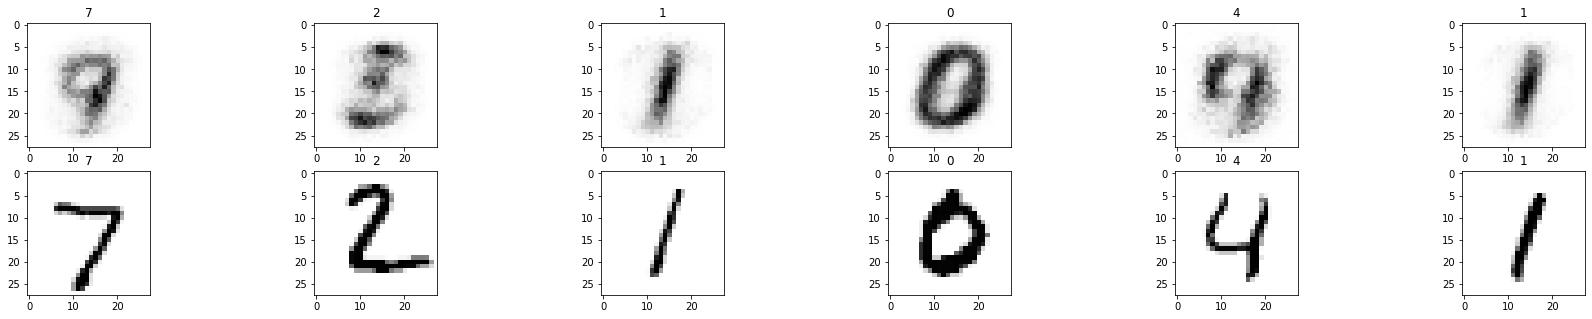

In [29]:
to_predict = x_test[:6]
prediction = stacked_ae.predict(to_predict)

def visualize_predictions(predictions, data):
    fig, axes = plt.subplots(2, predictions.shape[0], figsize = (predictions.shape[0]*5, 5))
    for i, ax in zip(range(predictions.shape[0]), axes[0, :]):
        ax.imshow(predictions[i], cmap = 'Greys')
        ax.set_title(y_test[i])
    for i, ax in zip(range(predictions.shape[0]), axes[1, :]):
        ax.imshow(x_test[i], cmap = 'Greys')
        ax.set_title(y_test[i])    
    return plt

visualize_predictions(prediction, to_predict)

#### Let us map the latent representations to 2 dimensions

In [30]:
# Select 1000 samples from data
X_test_sampled = x_test[:1000, :]
y_test_sampled = y_test[:1000]

# Visualizing the Latent representation - Taking the average of the volume
x_compressed = stacked_encoder.predict(X_test_sampled).mean(axis = -1).reshape(1000, -1)

# Use TSNE
tsne = TSNE(n_jobs=-1)
X_compressed_2d  =  tsne.fit_transform(x_compressed)

Text(0, 0.5, 'tsne 2')

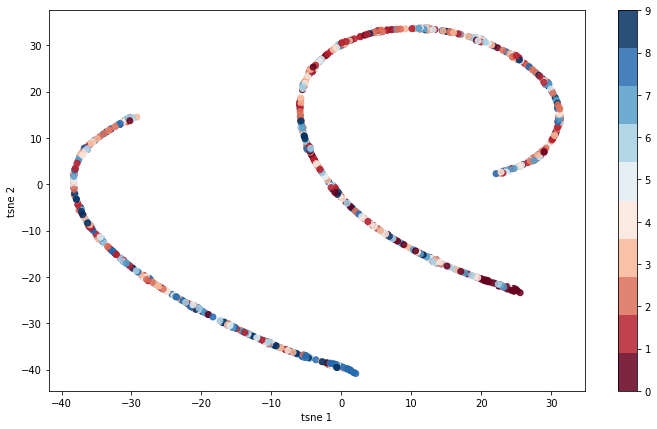

In [31]:
# Plot in scatterplot and color by digit name
plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(X_compressed_2d[:, 0], X_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')
#plt.colorbar(sc)

## Sparse Autoencoder

In [32]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(128, activation = 'selu'),
    keras.layers.Dense(32, activation = 'selu'),
    keras.layers.ActivityRegularization(l1=1e-3)
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(128, activation = 'selu', input_shape = (32, )),
    keras.layers.Dense(28*28, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_24 (Sequential)   (None, 32)                104608    
_________________________________________________________________
sequential_25 (Sequential)   (None, 28, 28)            105360    
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________


In [33]:
stacked_ae.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(lr=.1))

history  =  stacked_ae.fit(x_train, x_train, epochs = 20, validation_data = (x_test, x_test))

Epoch 1/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3405 - val_loss: 0.2793
Epoch 2/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2692 - val_loss: 0.2588
Epoch 3/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2495 - val_loss: 0.2385
Epoch 4/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2308 - val_loss: 0.2215
Epoch 5/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2158 - val_loss: 0.2087
Epoch 6/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2052 - val_loss: 0.1995
Epoch 7/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1970 - val_loss: 0.1916
Epoch 8/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1900 - val_loss: 0.1857
Epoch 9/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1846 - val_loss: 0.1806
Epoch 10/20
1875/1875 [==============================] - 9s 5ms/step - loss: 

<module 'matplotlib.pyplot' from '/Users/oybekeraliev/opt/anaconda3/envs/Tensorflow/lib/python3.7/site-packages/matplotlib/pyplot.py'>

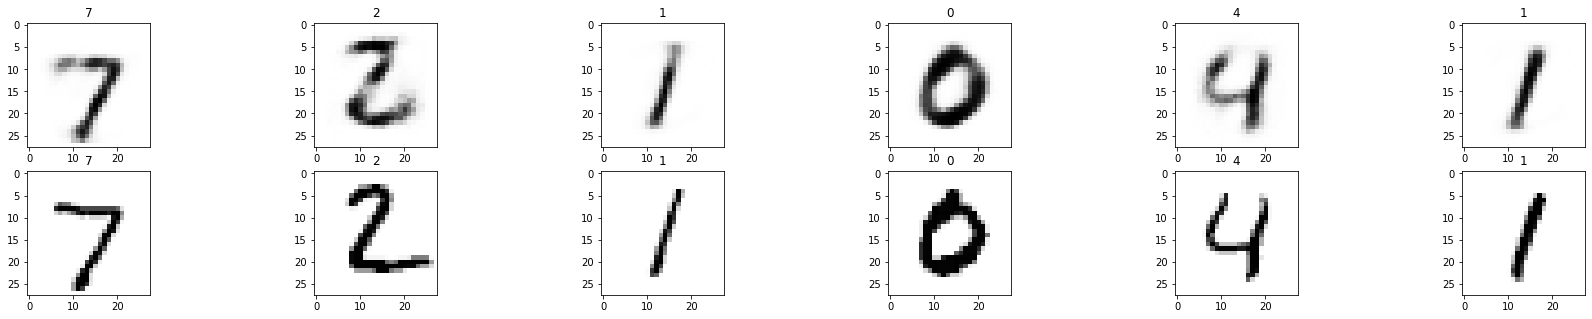

In [34]:
to_predict = x_test[:6]
prediction = stacked_ae.predict(to_predict)

def visualize_predictions(predictions, data):
    fig, axes = plt.subplots(2, predictions.shape[0], figsize = (predictions.shape[0]*5, 5))
    for i, ax in zip(range(predictions.shape[0]), axes[0, :]):
        ax.imshow(predictions[i], cmap = 'Greys')
        ax.set_title(y_test[i])
    for i, ax in zip(range(predictions.shape[0]), axes[1, :]):
        ax.imshow(x_test[i], cmap = 'Greys')
        ax.set_title(y_test[i])    
    return plt

visualize_predictions(prediction, to_predict)

In [35]:
# Select 1000 samples from data
X_test_sampled = x_test[:1000, :]
y_test_sampled = y_test[:1000]

# Visualizing the Latent representation - Taking the average of the volume
x_compressed = stacked_encoder.predict(X_test_sampled).mean(axis = -1).reshape(1000, -1)

# Use TSNE
tsne = TSNE(n_jobs=-1)
X_compressed_2d  =  tsne.fit_transform(x_compressed)

Text(0, 0.5, 'tsne 2')

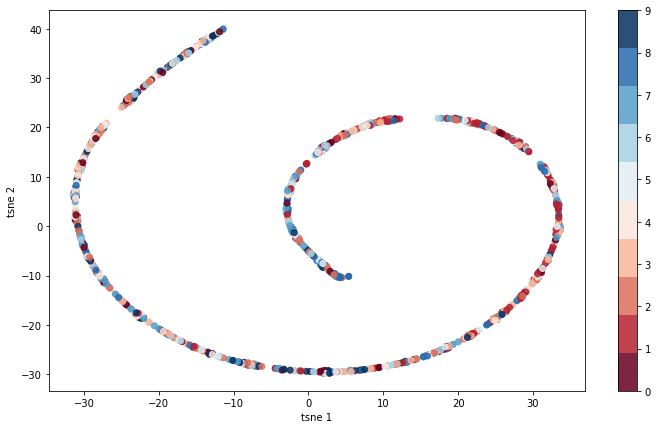

In [36]:
# Plot in scatterplot and color by digit name
plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(X_compressed_2d[:, 0], X_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')
#plt.colorbar(sc)

## Use CNNs to build the AutoEncoder

In [38]:
X_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
X_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [39]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'selu', input_shape = (28, 28, 1), padding = 'same'),
    keras.layers.MaxPooling2D(2, 2, padding = 'same'),
    keras.layers.Conv2D(8, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    keras.layers.MaxPooling2D(2, 2, padding = 'same'),
    keras.layers.Conv2D(8, kernel_size = (3,3), activation = 'selu', padding = 'same'),

])

stacked_decoder = keras.models.Sequential([
    keras.layers.Conv2D(8, kernel_size = (3,3), activation = 'selu', input_shape = (7,7,8), padding = 'same'),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2D(8, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    keras.layers.Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding = 'same'),

    
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_27 (Sequential)   (None, 7, 7, 8)           3216      
_________________________________________________________________
sequential_28 (Sequential)   (None, 28, 28, 1)         3793      
Total params: 7,009
Trainable params: 7,009
Non-trainable params: 0
_________________________________________________________________


In [40]:
stacked_ae.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(lr=.1))

history  =  stacked_ae.fit(X_train, X_train, epochs = 10, validation_data = (X_test, X_test))

Epoch 1/10
1875/1875 [==============================] - 208s 111ms/step - loss: 0.0989 - val_loss: 0.0824
Epoch 2/10
1875/1875 [==============================] - 206s 110ms/step - loss: 0.0815 - val_loss: 0.0789
Epoch 3/10
1875/1875 [==============================] - 174s 93ms/step - loss: 0.0784 - val_loss: 0.0768
Epoch 4/10
1875/1875 [==============================] - 175s 94ms/step - loss: 0.0766 - val_loss: 0.0764
Epoch 5/10
1875/1875 [==============================] - 175s 94ms/step - loss: 0.0753 - val_loss: 0.0745
Epoch 6/10
1875/1875 [==============================] - 163s 87ms/step - loss: 0.0743 - val_loss: 0.0736
Epoch 7/10
1875/1875 [==============================] - 168s 90ms/step - loss: 0.0735 - val_loss: 0.0721
Epoch 8/10
1875/1875 [==============================] - 188s 100ms/step - loss: 0.0728 - val_loss: 0.0724
Epoch 9/10
1875/1875 [==============================] - 177s 95ms/step - loss: 0.0722 - val_loss: 0.0713
Epoch 10/10
1875/1875 [=============================

<module 'matplotlib.pyplot' from '/Users/oybekeraliev/opt/anaconda3/envs/Tensorflow/lib/python3.7/site-packages/matplotlib/pyplot.py'>

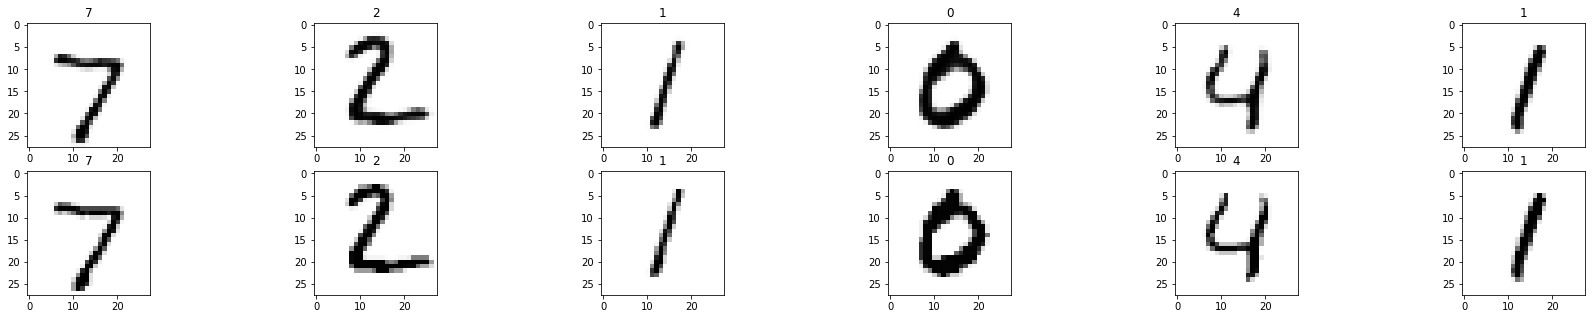

In [41]:
to_predict = X_test[:6]
prediction = stacked_ae.predict(to_predict)

def visualize_predictions(predictions, data):
    fig, axes = plt.subplots(2, predictions.shape[0], figsize = (predictions.shape[0]*5, 5))
    for i, ax in zip(range(predictions.shape[0]), axes[0, :]):
        ax.imshow(predictions[i], cmap = 'Greys')
        ax.set_title(y_test[i])
    for i, ax in zip(range(predictions.shape[0]), axes[1, :]):
        ax.imshow(X_test[i], cmap = 'Greys')
        ax.set_title(y_test[i])    
    return plt

visualize_predictions(prediction, to_predict)

In [42]:
# Select 1000 samples from data
X_test_sampled = X_test[:1000, :]
y_test_sampled = y_test[:1000]

# Visualizing the Latent representation - Taking the average of the volume
x_compressed = stacked_encoder.predict(X_test_sampled).mean(axis = -1).reshape(1000, -1)

# Use TSNE
tsne = TSNE(n_jobs=-1)
X_compressed_2d  =  tsne.fit_transform(x_compressed)

Text(0, 0.5, 'tsne 2')

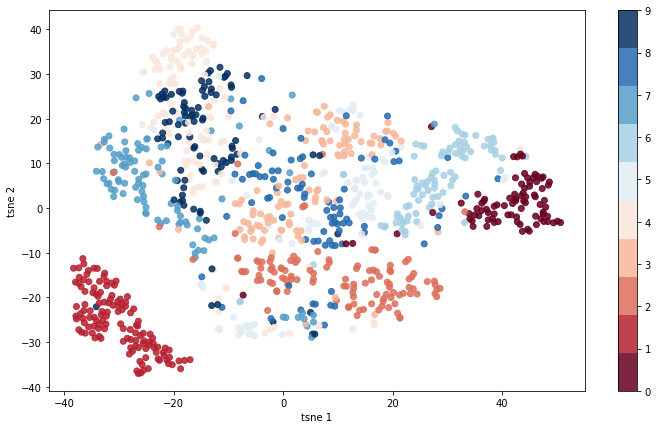

In [43]:
# Plot in scatterplot and color by digit name
plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(X_compressed_2d[:, 0], X_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')
#plt.colorbar(sc)